# Frequency Tracking Development
This notebook is used to develop a high precision frequency tracking mechanism

In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Fake Trace Generation

In [414]:
num_samples = 65536
data_dist = np.zeros(num_samples)
data_time = np.linspace(0,1,num_samples,endpoint=False)*0.15*100000000 + 420 #time in 10ns with initial offset

offset = 35000000000
noise_freqs = [1., 25., 50., 100., 200., 1500., 3000.] #noise frequencies in Hz
noise_amps = [100000., 300000., 60000., 1000., 90000., 8000., 500.] #noise amplitudes in pm
f_resonance = 24230.
a_resonance = 30000.

for i, f in enumerate(noise_freqs):
    data_dist += noise_amps[i] * np.sin(noise_freqs[i]*2.*np.pi*data_time/100000000. + np.random.rand()*2.*np.pi)
data_dist += offset
data_dist += a_resonance * np.sin(f_resonance*2.*np.pi*data_time/100000000. + np.random.rand()*2.*np.pi) * np.exp(-data_time/100000000.*15.)
print(data_dist)

[3.49996793e+10 3.49996739e+10 3.49996717e+10 ... 3.50002082e+10
 3.50002091e+10 3.50002100e+10]


<IPython.core.display.Javascript object>


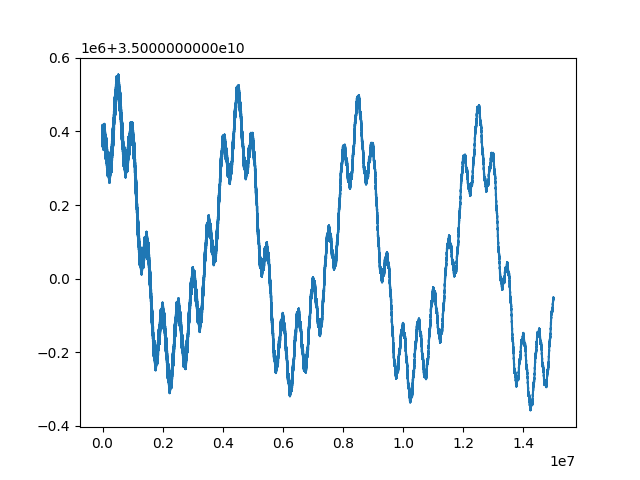

In [179]:
%matplotlib notebook
plt.plot(data_time, data_dist)

<IPython.core.display.Javascript object>


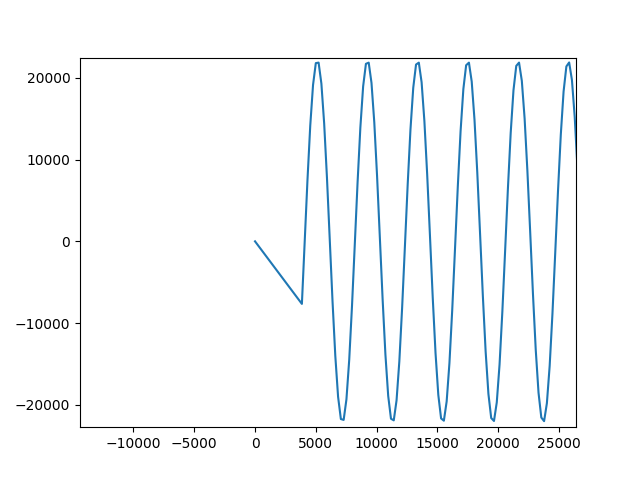

In [180]:
plt.cla()
plt.clf()
window = 15
data_dist_clean = np.zeros(len(data_dist))
data_time_clean = np.zeros(len(data_time))
for i in range(window,len(data_dist)):
    data_dist_clean[i] = data_dist[i] - np.mean(data_dist[i-int(window/2):i+int(window/2)])
    data_time_clean[i] = data_time[i]

plt.plot(data_time_clean, data_dist_clean)

In [361]:
f_drive = f_resonance+0.0033720363

In [363]:
plt.plot(data_time_clean[start:end]/1e8, data_dist_clean[start:end])
plt.plot(data_time_clean[start:end]/1e8, np.sin(f_drive*np.pi*2.*data_time_clean[start:end]/1e8)*1000., alpha=0.4)
plt.plot([data_time_clean[start]/1e8, data_time_clean[end-1]/1e8], [0,0], ls='dotted', c='b', lw=0.3)

In [364]:
#find reference zeros
zeros_meas = []
for k in range(len(data_dist_clean[start+1:end])):
    i = start+1+k
    if(data_dist_clean[i]*data_dist_clean[i-1] < 0.):#have sign change
        #calculate location of zero using linear interpolation
        m = (data_dist_clean[i] - data_dist_clean[i-1])/(data_time_clean[i]-data_time_clean[i-1])
        q = m * data_time_clean[i] - data_dist_clean[i]
        zeros_meas.append(-q/m)

In [365]:
data_calc = np.sin(f_drive*np.pi*2.*data_time_clean[start:end]/1e8)*1000.
time_calc = data_time_clean[start:end]/1e8

In [366]:
zeros_calc = []
for k in range(1, len(data_calc)):
    if(data_calc[k]*data_calc[k-1] < 0.):#have sign change
        #calculate location of zero using linear interpolation
        if(time_calc[k] == time_calc[k-1]):
            continue
        m = (data_calc[k] - data_calc[k-1])/(time_calc[k]-time_calc[k-1])
        q = m * time_calc[k] - data_calc[k]
        zeros_calc.append(-q/m)

In [367]:
plt.plot(data_time_clean[start:end]/1e8, data_dist_clean[start:end])
plt.plot(time_calc, data_calc, alpha=0.4)
plt.plot([data_time_clean[start]/1e8, data_time_clean[end-1]/1e8], [0,0], ls='dotted', c='b', lw=0.3)
plt.scatter(-np.array(zeros_meas)/1e8,[0]*len(zeros_meas), c='r', s=10)
plt.scatter(-np.array(zeros_calc),[0]*len(zeros_calc), c='g', s=10)

In [368]:
zeros_dists = []
zeros_times = []
for i in range(min(len(zeros_calc), len(zeros_meas))):
    zeros_dists.append(zeros_calc[i] - zeros_meas[i]/1e8)
    zeros_times.append(-(zeros_calc[i]+zeros_meas[i]/1e8)/2.)
print(zeros_times)

[4.106345174579088e-05, 6.170649186838563e-05, 8.233962111598959e-05, 0.00010297400732823666, 0.0001236150153117232, 0.00014424188919344338, 0.00016488958549812013, 0.0001855104083354424, 0.00020616290291280244, 0.0002267801886746266, 0.0002474342965135081, 0.0002680519163788096, 0.0002887032576608752, 0.00030932588366431126, 0.00032996987698971614, 0.00035060163993961803, 0.0003712350422808888, 0.0003918779795162076, 0.0004125002489993396, 0.00043315331571342527, 0.0004537670867379236, 0.0004744262754502904, 0.0004950366458538334, 0.0005156962205921258, 0.0005363091376647846, 0.0005569634376794321, 0.0005775839111830537, 0.0005982289160020584, 0.0006188598387454191, 0.0006394938525002465, 0.0006601358490377831, 0.0006807591581292356, 0.0007014113190045635, 0.000722025221211337, 0.0007426861334139833, 0.0007632920228540063, 0.0007839604235552098, 0.0008045594903363816, 0.0008252341853404696, 0.0008458278366643534, 0.0008665070432316053, 0.0008870976485832126, 0.0009077783329008817, 0.0

In [369]:
plt.plot(zeros_times, zeros_dists, '*-')
m,q = np.polyfit(zeros_times, zeros_dists, 1)
plt.plot([zeros_times[0], zeros_times[-1]], [m*zeros_times[0] + q, m*zeros_times[-1]+q])

<IPython.core.display.Javascript object>

In [370]:
error = m*f_drive
better_error = m*(f_drive-error/2.)
print(f"Error FO: {error}")
print(f"Error HO: {better_error} Hz")
print(f"Real Frequency: {f_drive-better_error}")

Error FO: 0.0033858336383305303
Error HO: 0.0033858334017670176 Hz
Real Frequency: 24229.999986202896


In [418]:
#data time and data_dist are measured, f_drive is best guess for resonance frequency
def frequencyTrackingPE(data_time, data_dist, f_drive):
    #filter the data
    window = 15
    start = window
    end = -window
    data_dist_clean = np.zeros(len(data_dist))
    data_time_clean = np.zeros(len(data_time))
    for i in range(window,len(data_dist)):
        data_dist_clean[i] = data_dist[i] - np.mean(data_dist[i-int(window/2):i+int(window/2)])
        data_time_clean[i] = data_time[i]
    
    #find zeros in the filtered data
    #find reference zeros
    zeros_meas = []
    for k in range(len(data_dist_clean[start+1:end])):
        i = start+1+k
        if(data_dist_clean[i]*data_dist_clean[i-1] < 0.):#have sign change
            #calculate location of zero using linear interpolation
            m = (data_dist_clean[i] - data_dist_clean[i-1])/(data_time_clean[i]-data_time_clean[i-1])
            q = m * data_time_clean[i] - data_dist_clean[i]
            zeros_meas.append(-q/m)
    
    data_calc = np.sin(f_drive*np.pi*2.*data_time_clean[start:end]/1e8)*1000.
    time_calc = data_time_clean[start:end]/1e8
    #find zeros in drive data
    zeros_calc = []
    for k in range(1, len(data_calc)):
        if(data_calc[k]*data_calc[k-1] < 0.):#have sign change
            #calculate location of zero using linear interpolation
            if(time_calc[k] == time_calc[k-1]):
                continue
            m = (data_calc[k] - data_calc[k-1])/(time_calc[k]-time_calc[k-1])
            q = m * time_calc[k] - data_calc[k]
            zeros_calc.append(-q/m)
    
    #calculate change in zero distance
    zeros_dists = []
    zeros_times = []
    for i in range(min(len(zeros_calc), len(zeros_meas))):
        zeros_dists.append(zeros_calc[i] - zeros_meas[i]/1e8)
        zeros_times.append(-(zeros_calc[i]+zeros_meas[i]/1e8)/2.)
    
    #calculate implied frequency error
    m,q = np.polyfit(zeros_times, zeros_dists, 1)
    error = m*f_drive
    better_error = m*(f_drive-error/2.)
    
    #return corrected frequency
    return f_drive - better_error

In [419]:
frequencyTrackingPE(data_time, data_dist, 24250)

24229.99995897857

In [420]:
print(start)
print(end)

15
-15


# Working with the RL20001

In [40]:
import rl20001

In [42]:
myRelay.close()

In [41]:
myRelay = rl20001.RL20001('COM4')

Numato USB Relay Connected Successfully


In [11]:
myRelay.turnOn()

In [12]:
myRelay.getState()

True

In [35]:
import serial
ser = serial.Serial('COM4', baudrate=9600, timeout=1)

In [36]:
import time

In [527]:
state = "on"
ser.write(f"relay {state} 0\x0D".encode())
time.sleep(0.01)
ser.write(f"relay {state} 1\x0D".encode())
time.sleep(1)
text = ""
while(ser.in_waiting):
    text += ser.read().decode()
print(text)

relay on 0
>relay on 1
>


In [45]:
state = "read"
ser.write(f"relay {state} 0\x0D".encode())
text = ""
time.sleep(0.5)
while(ser.in_waiting):
    text += ser.read().decode()
print(text.split('\n\r'))

['relay read 0', 'on', '>']


In [494]:
ser.readline()

b''

In [39]:
myRelay.close()

NameError: name 'myRelay' is not defined

None


# Working with Hookshot

In [36]:
import element
myElement = element.Element()

In [37]:
myElement.warn("Does this really work?")

# Working with the PQWSW2 (Mystrom Smart Switch)

In [1]:
import pqwsw2

In [2]:
mySwitch = pqwsw2.PQWSW2('192.168.254.1')

Smart Switch Connected Successfully


In [33]:
mySwitch.getState()

True

In [34]:
mySwitch.getPower()

57.13